# Railway Fault Track Detection
A simple Deep Learning project with Convolutional Neural Network (CNN) to detect faulty images of railway tracks.

## Packages
Import all the necessary packages

In [1]:
# general
import os
import random

# kaggle for datasets
import kagglehub

# pytorch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# matplotlib
import matplotlib.pyplot as plt

# scikit learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# numpy
import numpy as np

## Loading data
Download the dataset automatically from kaggle.

NOTE: we need to find the correct path of our dataset

In [ ]:
# download dataset and get the path
path = kagglehub.dataset_download("salmaneunus/railway-track-fault-detection")

# check path is pointing to Train/Test/Validation folders
# print(os.listdir(path))

# adjust path
path = path + "/Railway Track fault Detection Updated"

100%|██████████| 2.00G/2.00G [00:24<00:00, 87.6MB/s]

Extracting files...


Let's now explore the dataset structure to get insights on how data is stored.

Print subfolders names up to .jpg files

In [ ]:
# explore dataset structure
# vuole vedere come è strutturato il dataset nelle cartelle, fino ad arrivare a tutte
# le sottocartelle che effettivamente contengono le immagini
def print_structure_to_image_folders(root_dir, indent=0):
    try:
        items = os.listdir(root_dir)
        # check if this folder contains any jpg files
        jpg_files = [f for f in items if os.path.isfile(os.path.join(root_dir, f)) and f.lower().endswith('.jpg')]
        if jpg_files:
            # if jpg files inside, print folder name and stop going deeper
            print('  ' * indent + os.path.basename(root_dir) + '/')
        else:
            # otherwise, print folder name and go deeper into subfolders
            print('  ' * indent + os.path.basename(root_dir) + '/')
            for item in sorted(items):
                full_path = os.path.join(root_dir, item)
                if os.path.isdir(full_path):
                    print_structure_to_image_folders(full_path, indent + 1) # recursive call to subfolders
    except Exception as e:
        print(f"Error accessing {root_dir}: {e}")

print_structure_to_image_folders(path)

Railway Track fault Detection Updated/
  Test/
    Defective/
    Non defective/
  Train/
    Defective/
    Non defective/
  Validation/
    Defective/
    Non defective/


Preprocess images and get data loaders

In [ ]:
# datasets paths
train_data_dir = os.path.join(path, "Train")
valid_data_dir = os.path.join(path, "Validation")
test_data_dir = os.path.join(path, "Test")

# transform operation when loading each image
# Pytorce permette di fare già un preprocessing iniziale. Le immagini standard sono giganti
# quindi si riduce la dimensione arrivando ad allenare un modello più snello

transform = transforms.Compose([
    transforms.Resize((224, 224)),      # resize the image to 224x224. E' abbastanza arbitraria
    transforms.ToTensor(),              # Fa 3 cose:
                                        # 1) convert the image to a PyTorch tensor (sono vettori),
                                        # 2) scale pixel values in [0,1] (tutto stesso ordine di grandezza)
                                        # 3) reshape the image from (Height, Width, Channel) to (C, H, W), perché
                                        #    Pytorch li vuole in questo ordine
])


# datasets.ImageFolder() of Pytorch allows to load images from a directory structure where each subfolder is a class.
# A label is assigned to each image corresponding to the subfolder name
# Es: Le immagini della cartella "defective" avranno label "defective"

# crea il train dataset
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform) # load images from path e fa
                                                                               # il transform creato prima

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # create pytorch dataloader permette poi di
                                                                      # iterare con i dati, caricarli per allenare ecc..
                                                                      # si definisce anche il batch_size, 32 è arbitrario
                                                                      # shuffle, ogni volta shuffla
print(f"Loaded {len(train_dataset)} training images")

# come prima
# crea validation dataset
valid_dataset = datasets.ImageFolder(root=valid_data_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
print(f"Loaded {len(valid_dataset)} validation images")

# crea test dataset
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
print(f"Loaded {len(test_dataset)} test images")

Loaded 300 training images
Loaded 62 validation images
Loaded 22 test images


## Exploration Data Analysis (EDA)
Look at some samples in the dataset and check lables distribution in train/test/valid to make sure the dataset is well balanced.

First, have a look to label values.

In [ ]:
# get name of labels
print(train_dataset.classes) # mostra la lista delle classi, in questo caso
                             # defective e non-defective
# Verifico un pò che i dati caricati siano corretti
# print label for 5 random images in the dataset
# le label sono numeri che corrispondono alle label
# 0->defective , 1->non defective
for _ in range(5):
    rand_id = random.randint(0, len(train_dataset))
    image, label = train_dataset[rand_id] # get random sample
    print(f"Image {rand_id} has label {label} corresponding to \"{train_dataset.classes[label]}\"") # print associated label and class

['Defective', 'Non defective']
Image 242 has label 1 corresponding to "Non defective"
Image 280 has label 1 corresponding to "Non defective"
Image 211 has label 1 corresponding to "Non defective"
Image 125 has label 0 corresponding to "Defective"
Image 96 has label 0 corresponding to "Defective"


### Visualizing some samples
Visualize some random images with associated label

In [ ]:
# a simple function to visualize some random samples with associated labels
def visualize_rand_samples(dataset, title, num_samples=6, figsize=(12, 8)):

    plt.figure(figsize=figsize) # create plot

    for i in range(num_samples): # plot 6 rand images

        rand_id = random.randint(0, len(train_dataset))
        image, label = train_dataset[rand_id] # get random sample

        ax = plt.subplot(2, 3, i + 1)
        ax.imshow(image.permute(1, 2, 0).numpy())  # permute to (H, W, C) for visualization
        ax.set_title(f"Label: {train_dataset.classes[label]}") # print class name
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# training dataset
visualize_rand_samples(train_dataset, "Random sample from Training dataset")

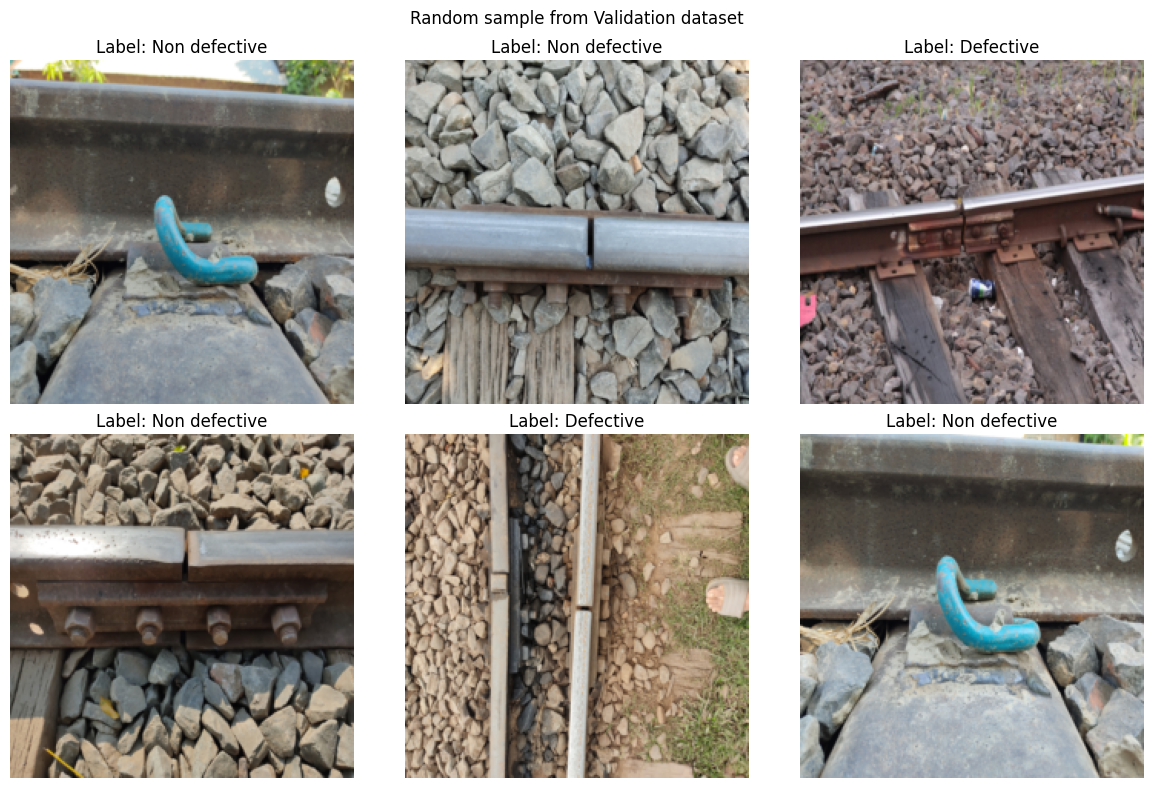

In [ ]:
# validation dataset
visualize_rand_samples(valid_dataset, "Random sample from Validation dataset")

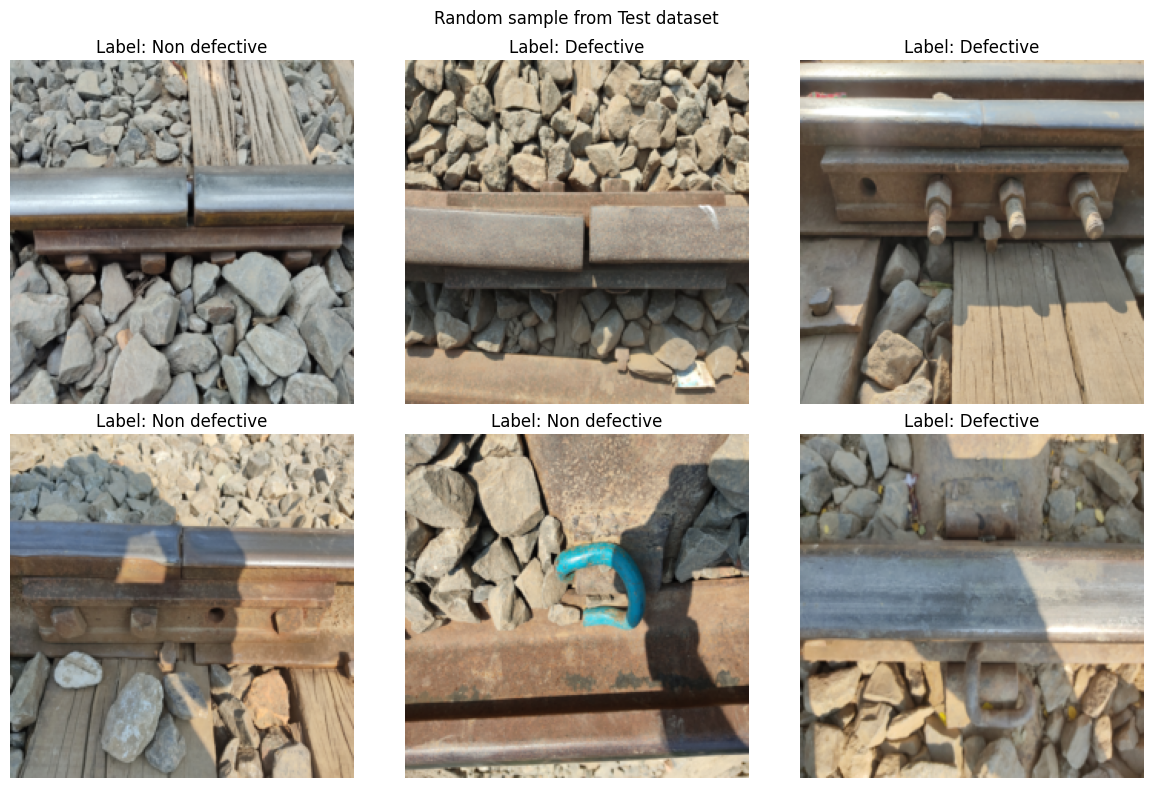

In [ ]:
# test dataset
visualize_rand_samples(test_dataset, "Random sample from Test dataset")

### Labels distribution

In [ ]:
# Si guarda alla distribuzione delle label, voglio una distribuzione bilanciata
# di defective e non defective

# get labels from a dataset
def get_num_labels(dataset):

    labels = [label for _, label in dataset.samples] # get list of all samples
    return np.bincount(labels) # count labels

train_labels = get_num_labels(train_dataset) # train labels
valid_labels = get_num_labels(valid_dataset) # valid labels
test_labels = get_num_labels(test_dataset) # test labels

# print labels distribution
print(f"Train labels distribution: {train_labels}")
print(f"Valid labels distribution: {valid_labels}")
print(f"Test labels distribution:  {test_labels}")

Train labels distribution: [150 150]
Valid labels distribution: [31 31]
Test labels distribution:  [11 11]


## Prediction model
Let's now create our prediction model: a simple CNN architecture with the following layers:

* conv2d (16 filters, kernel size 3x3) ->
* maxpooling (2x2) -> Una volta applicati i filtri si ottiene una "nuova immagine" della quale si prende sono il valore massimo tra i 2x2 valori alla volta. Invece di considerare tutte le feature estratte si prende sono quella più "grande", quella più "importante" e ci si concentra su quella. Esistono poi minpooling, meanpooling, vanno provate.

* conv2d (32 filters, kernel size 3x3)
* maxpooling (2x2)
* flatten layer ->
* linear layer -> Prendono le feature estratte con i layer precedenti, le elaborano e le usano per classificare.

* linear layer (out dimension = 1) -> perché deve predirre 0 o 1

Convolutional layers extract features from the images. It is common in CNN to add maxpooling layers to enhance the extracted features from convolutional layers.

Then, the linear layers process the extracted features from convolutional layers to make predict the desired value. In this case we use two linear layers, where the output dimension is 1 (we want to predict only two classes, so 0,1 values).

Feel free to change the structure of the model and/or the size of the layers!

In [ ]:
# nn.Module : classe di base di Pytorch per le NN
class ClassifierCNN(nn.Module):
    def __init__(self):
        super(ClassifierCNN, self).__init__() # initalize nn.Module (base pytorch class for NN architectures)

        # Mette tutti i layer che vuole utilizzare
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)   # input: (B, 3, 224, 224)  -> output: (B, 16, 224, 224)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # input: (B, 16, 224, 224) -> output: (B, 16, 112, 112) # stride 2 perché con 1 i kernel si sovrapporrebbero,
                                                                                                                                    # quindi così si prende il max tra valori diversi. L'output
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)            # input: (B, 16, 112, 112) -> output: (B, 32, 112, 112)
        self.pool2 = nn.MaxPool2d(2, 2)                                     # input: (B, 32, 112, 112) -> output: (B, 32, 56, 56)   # avendo stride 2 si passa da 112 a 56

        # Le immagini hanno 3 dimensioni, una per colore quindi vengono messi in fila essenzialmente
        # creando un array quindi, poter dare il tutto poi in ingresso all'input layer della NN
        self.flatten = nn.Flatten()                                         # input: (B, 32, 56, 56)   -> output: (B, 64 * 56 * 56) just get layer ready for linear
        self.fc1 = nn.Linear(32 * 56 * 56, 70)                              # input: (B, 32 * 56 * 56) -> output: (B, 70)   # 70 è arbitrario
        self.fc2 = nn.Linear(70, 1)                                         # input: (B, 70)           -> output: (B, 1)

    # L'ordine con cui sono scritti i layer non sono quelli in cui passano i dati
    # Va quindi creata la funziona forward dove x sono i dati essernzialmente

    # forward function, this defined the flow of our data inside our NN
    def forward(self, x): # x is our input image
        # Si usa relu perché di solito funziona bene
        x = F.relu(self.conv1(x)) # first, passage through convolutional layer, then apply relu activation (non-lineaity to learn complex patterns)

        x = self.pool1(x) # max pooling
        x = F.relu(self.conv2(x)) # passage through second convolutional layer
        x = self.pool2(x) # max pooling
        x = self.flatten(x) # flattening features
        x = F.relu(self.fc1(x)) # passage through linear layer

        # Fino alla riga prima x essenzialmente è un numero, applico allo
        # la sigmoid che forza il valore tra 0 oppure 1, diventa essenzialmente
        # la probabilità di appartenenza ad una classe
        # Poi va definito in post processing il threshold per classificare
        # correttamente la roba
        x = torch.sigmoid(self.fc2(x)) # passage through second linear layer with sigmoid for binary classification
        return x

## Training

Initialize the model and train it

In [ ]:
# get the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create the model
model = ClassifierCNN().to(device)

# print the model summary to check model structure is ok
summary(model, input_size=(3, 224, 224))

# Generalmente i layer convoluzionali hanno pochi parametri
# Quelli lineari ne hanno tanti
# Si possono definire dei parametri da NON allenare

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
           Flatten-5               [-1, 100352]               0
            Linear-6                   [-1, 70]       7,024,710
            Linear-7                    [-1, 1]              71
Total params: 7,029,869
Trainable params: 7,029,869
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 12.25
Params size (MB): 26.82
Estimated Total Size (MB): 39.64
----------------------------------------------------------------


Define some training parameters (feel free to change them!)

In [ ]:
# Training parameters

# Perché sto valore? Boh, avendo normalizzato i dati generalmente questi son valori che funzionano bene
lr = 0.001 # learning rate
loss_function = nn.BCELoss() # binary cross entropy loss for binary classification
                             # Confronta due distribuzioni di probabilità, tratta gli ouput del modello
                             # come distribuzioni di probabilità
                             # Nella classificazione è quella che funziona meglio
num_epochs = 20 # training epochs

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # set Adam as model optimizer

Training loop. At each iteration:
* perform backpropagation on training data to compute loss and update model's parameters
* compute loss on the validation to evaluate model's performance on data that is not used in training (to avoid overfitting)

In [ ]:
# keep track of the best model checkpoint
best_val_loss = float('inf')
best_model_state = None

# Training loop: Ciclo che permette di dire per ogni sample faccio il pass, poi
# ottimizza i parametri, riparte ecc..
for epoch in range(num_epochs): # Per ogni epoca

    model.train() # set the model to training mode. Permette di aggiornare i pesi
                  # del modello
    train_loss = 0.0  # Variabili per segnarsi ad ogni epoca sta roba
    correct = 0
    total = 0

    # iterate over the training data
    for images, labels in train_loader: # Questo è un ciclo di training set

        # .to(device) per mandare i dati alla GPU
        images = images.to(device) # shape: (B, 3, 224, 224)
        labels = labels.float().unsqueeze(1).to(device)  # shape: (B, 1)

        optimizer.zero_grad() # reset gradients before backpropagation
        outputs = model(images) # get model predictions
        loss = loss_function(outputs, labels) # calculate loss
        loss.backward() # backpropagation
        optimizer.step() # update weights

        # Calcolo di alcuni parametri di performance
        train_loss += loss.item() * images.size(0) # get total loss (to compute avg loss at the end)

        # Qui si assegna 0 od 1 avendo scelto il threshold 0.5
        preds = (outputs > 0.5).float() # get predictions (0 or 1) using a threshold of 0.5
        correct += (preds == labels).sum().item() # get the number of correct predictions
        total += labels.size(0) # total num of samples (to compute avg loss and accuracy at the end)

    train_loss = train_loss / total # compute avg train loss
    train_epoch_acc = correct / total # compute train accuracy


    # compute metrics on validation set
    model.eval() # set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    # with torch.no_grad() vuol dire che non si andrà a lavorare col gradiente
    # è per essere sicuri di non andare a toccare i pesi nel caso non si metta
    # il modello in modalità evaluation
    with torch.no_grad(): # no need to compute gradients
        for images, labels in valid_loader:
            images = images.to(device) # shape: (batch, 3, 224, 224)
            labels = labels.float().unsqueeze(1).to(device)  # shape: (batch, 1)

            outputs = model(images) # get model predictions
            loss = loss_function(outputs, labels) # calculate loss

            val_loss += loss.item() * images.size(0) # get total loss (to compute avg loss at the end)
            preds = (outputs > 0.5).float() # get predictions (0 or 1) using a threshold of 0.5
            correct += (preds == labels).sum().item() # get the number of correct predictions
            total += labels.size(0) # total num of samples (to compute avg loss and accuracy at the end)

    val_loss = train_loss / total # compute avg valid loss
    val_epoch_acc = correct / total # compute valid accuracy

    # Stampa come si sta comportando il modello durante la validation alla fine
    # di ogni epoca
    print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f} | Train accuracy: {train_epoch_acc:.4f} --- Valid loss: {val_loss:.4f} | Valid accuracy: {val_epoch_acc:.4f}")

    # save checkpoint if validation loss improved

    # Se sta miglioando allora mi salvo sottoforma di dizionario i valori dei
    # parametri/pesi del modello, con model.state_dict()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict() # save model's parameters

Epoch 1/20 | Train loss: 1.1371 | Train accuracy: 0.4933 --- Valid loss: 0.0183 | Valid accuracy: 0.5000
Epoch 2/20 | Train loss: 0.6807 | Train accuracy: 0.5133 --- Valid loss: 0.0110 | Valid accuracy: 0.5161
Epoch 3/20 | Train loss: 0.6518 | Train accuracy: 0.6400 --- Valid loss: 0.0105 | Valid accuracy: 0.5484
Epoch 4/20 | Train loss: 0.6134 | Train accuracy: 0.7000 --- Valid loss: 0.0099 | Valid accuracy: 0.5806
Epoch 5/20 | Train loss: 0.5294 | Train accuracy: 0.7867 --- Valid loss: 0.0085 | Valid accuracy: 0.6452
Epoch 6/20 | Train loss: 0.4243 | Train accuracy: 0.8767 --- Valid loss: 0.0068 | Valid accuracy: 0.8387
Epoch 7/20 | Train loss: 0.3440 | Train accuracy: 0.8567 --- Valid loss: 0.0055 | Valid accuracy: 0.6935
Epoch 8/20 | Train loss: 0.3309 | Train accuracy: 0.8767 --- Valid loss: 0.0053 | Valid accuracy: 0.7419
Epoch 9/20 | Train loss: 0.2507 | Train accuracy: 0.9467 --- Valid loss: 0.0040 | Valid accuracy: 0.7581
Epoch 10/20 | Train loss: 0.1840 | Train accuracy: 0.95

## Evaluation
After training and saving the best checkpoint of the model (based on validation set loss), let's perform the final evaluation on the test set

In [ ]:
# Ha overfittato un sacco quindi forse il modello è troppo "potente" per
# questo dataset

# Come performa il modello migliore sul test set?

model.load_state_dict(best_model_state) # load best checkpoint params
                                        # il modello con cui si è ottenute una
                                        # valid accuracy di 0.8387
model.eval()  # evaluation mode
test_loss = 0.0
correct = 0
total = 0

all_preds = [] # some lists to store model's predictions and compute metrics
all_labels = []

# same as for the validation set
with torch.no_grad():
    for images, labels in test_loader: # use test dataloader instead
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)

        test_loss += loss.item() * images.size(0)

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # store preds and true labels

        # si fa essenzialmente un append e le si mette in cpu dato che la gpu
        # la si usa solo per fare il training del modello
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# compute and print final accuracy
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Con Test Accuracy: 0.5909 è evidente che si sta overfittando mentre in training
# era del 100 e anche alta in validation

Test Accuracy: 0.5909


Now plot confusion matrix

In [ ]:
# convert from list of arrays to flat arrays
all_preds = np.array(all_preds).astype(int).flatten().tolist()
all_labels = np.array(all_labels).astype(int).flatten().tolist()

# get confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-defective", "Defective"])

# plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title("Confusion Matrix - Test Set")
plt.show()